A template for plotting the results of multiple monte-carlo analyses.


In [3]:
import pandas as pd
import re
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Helper functions

In [4]:
def extract_logs_from_file(file_path, skip_lines=0):
    log_data = []
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the specified number of lines
        for line in file:
            entry_data = {}
            log_entries = line.strip().split(', ')
            for entry in log_entries:
                var_name, var_value = entry.split('=')
                entry_data[var_name] = var_value
                try:
                    var_value = pd.to_numeric(var_value)
                except ValueError:
                    pass
                entry_data[var_name] = var_value
            log_data.append(entry_data)
    return pd.DataFrame(log_data)


def extract_logs_from_file_smart(file_path, skip_lines=0):
    log_data = []

    # Regular expression to match "varname=value"
    log_entry_pattern = re.compile(r'(\w+)=([\d.Ee+-]+|\w+|".*?"|\'.*?\')')

    with open(file_path, 'r') as file:
        # Skip the specified number of lines
        for _ in range(skip_lines):
            next(file)
        
        for line in file:
            entry_data = {}
            log_entries = log_entry_pattern.findall(line)
            if not log_entries:
                # print(f"Warning: No valid log entries found in line: {line}")
                continue

            for var_name, var_value in log_entries:
                # Attempt to convert var_value to a numeric type if possible
                try:
                    var_value = pd.to_numeric(var_value)
                except ValueError:
                    # If it's not a numeric type, strip quotes if present
                    var_value = var_value.strip('"').strip("'")
                entry_data[var_name] = var_value
            
            log_data.append(entry_data)
    
    if not log_data:
        print("Warning: No valid data extracted from the log file.")
    return pd.DataFrame(log_data)

def append_dataframes_from_files(file_list):
    dataframes = []
    for file_path in file_list:
        print(file_path)
        df = extract_logs_from_file_smart(file_path)
        dataframes.append(df)

    # Concatenate all the dataframes into a single one
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    return concatenated_df

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram_with_kde(df, column, color='blue', bins=30, save_path=None, xlabel=None, ylabel=None, rescale=None, ci_type='68',
                            xlim=None, ylim = None, major_ticks_num=None):
    """
    Plots a histogram with a KDE plot for a specified column in the dataframe
    within specified confidence interval from the mean and shows probability on the y-axis.
    Also calculates and displays the standard error of the mean (SEM).
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name for which to plot the histogram and KDE.
        bins (int): The number of bins for the histogram.
        save_path (str): File path to save the plot as an image. If None, the plot is not saved.
        xlabel (str): Custom x-axis label. If None, defaults to the column name.
        ylabel (str): Custom y-axis label. If None, defaults to 'Probability'.
        rescale (int, float): Value to rescale the data e.g., 10**6 to convert to million scale. If None, data is not rescaled.
        ci_type (str): Confidence interval type. '68' for 68% confidence interval, '90' for 90% confidence interval.
        xlim (tuple): Limits for the x-axis.
        major_ticks_num (int): Number of major ticks on the x-axis.
    """
    
    if rescale:
        df[column] = df[column] / rescale

    # Calculate mean, median, and standard deviation
    mean = df[column].mean()
    std_dev = df[column].std()
    median = df[column].median()

    # Determine the number of standard deviations for the specified confidence interval
    if ci_type == '68':
        lower_pct = 16
        upper_pct = 84
        ci_label = '68% CI'
    elif ci_type == '90':
        lower_pct = 5
        upper_pct = 95
        ci_label = '90% CI'
    else:
        raise ValueError("ci_type must be '68' or '90'")

    # Calculate the percentiles for highlighting
    pct_lower = np.percentile(df[column], lower_pct)
    pct_upper = np.percentile(df[column], upper_pct)

    # Filter limit to include 99% of the data
    lower_limit = mean - 2 * std_dev
    upper_limit = mean + 2 * std_dev
    filtered_data = df[(df[column] >= lower_limit) & (df[column] <= upper_limit)].copy()

    plt.figure(figsize=(4.8, 4.8))

    # Plot the histogram with KDE, normalize the histogram (y axis as probability)
    sns.histplot(filtered_data[column], kde=True, bins=bins, color=color, edgecolor='black', linewidth=1.5, stat='probability')

    # Customize plot appearance
    plt.gca().spines['top'].set_linewidth(2)
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    if major_ticks_num:
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(major_ticks_num))

    # Set major and minor ticks clearly visible inside the axes
    plt.gca().tick_params(axis='x', which='major', direction='out', length=6, width=1, color='black', labelsize=20)
    plt.gca().tick_params(axis='y', which='major', direction='in', length=6, width=1, color='black', labelsize=20)

    if xlabel:
        plt.xlabel(xlabel, fontsize=20)
    else:
        plt.xlabel(column, fontsize=20)

    if ylabel:
        plt.ylabel(ylabel, fontsize=20)
    else:
        plt.ylabel('Probability', fontsize=20)

    # Plot mean and median lines
    plt.axvline(mean, color='r', linestyle='--', linewidth=2, label='Mean')

    # Highlight the confidence interval percentile range
    plt.axvspan(pct_lower, pct_upper, color='gray', alpha=0.3, label=ci_label)

    plt.legend(fontsize=16)

    if xlim:
        plt.xlim(xlim)

    if ylim:
        plt.ylim(ylim)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='none')

    plt.show()

    print("Mean: {:.2f}".format(mean))
    print("Median: {:.2f}".format(median))
    print(f"{lower_pct}th Percentile: {pct_lower:.2f}")
    print(f"{upper_pct}th Percentile: {pct_upper:.2f}")

## File extraction

If running the notebook on your personal workstation, change the path to files to that of your local data directory

In [6]:
path_to_files = r'../'

In [ ]:
#The name of the folder containing the desired .out files
name = "M3-1001-2X"

In [10]:
file_list = glob.glob(path_to_files + "../montecarlo_tdtr/out/" + name + "/*/*.out")
df = append_dataframes_from_files(file_list)
file_list

ValueError: No objects to concatenate

## Plotted data

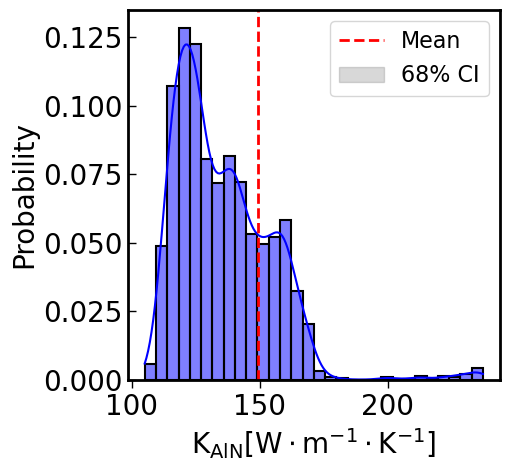

Mean: 149.18
Median: 135.40
16th Percentile: nan
84th Percentile: nan


In [ ]:
plot_histogram_with_kde(df, 'k_AlN', bins=30, 
    xlabel = '$\mathrm{K}_{\mathrm{AlN}}  [\mathrm{W \cdot m^{-1} \cdot K^{-1}}]$',
    save_path = name + '_k-AlN.png', ci_type = '68')

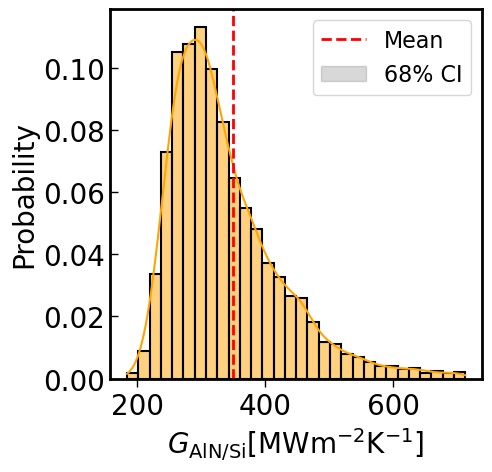

Mean: 350.05
Median: 318.30
16th Percentile: nan
84th Percentile: nan


In [ ]:
plot_histogram_with_kde(df, 'G_AlN_Si', bins=30, rescale = 1e6, color = 'orange',
    xlabel = '$G_{\mathrm{AlN/Si}} [\mathrm{MW m^{-2} K^{-1}}]$',
    save_path = name + '_G-AlN-Si.png', ci_type = '68')